# LightGBM Forecasting Pipeline

**Author:** Claire Yao  
<br>
**Description:**  
This script loads M5 competition data, performs preprocessing, builds lag and calendar-based features, and trains LightGBM quantile regression models for demand forecasting.


## Data Overview

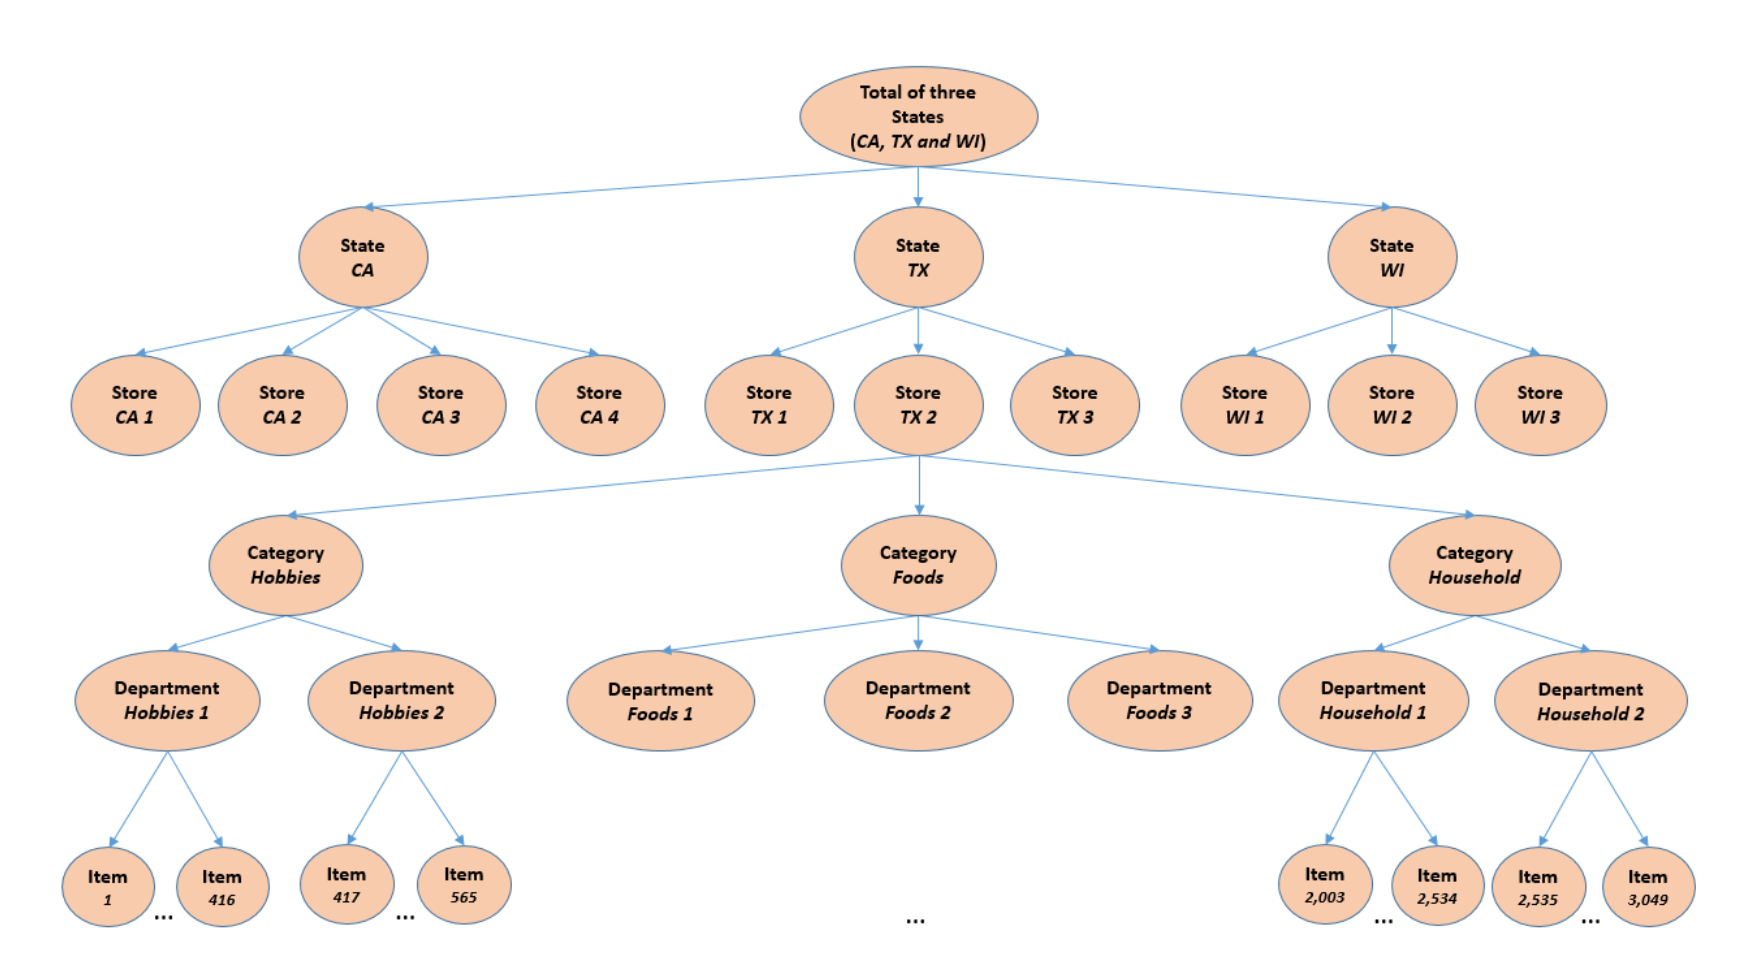

#### File 1: “calendar.csv” 
Contains information about the dates the products are sold.
| **Field Name**   | **Description**                                                                 |
|------------------|---------------------------------------------------------------------------------|
| `date`           | Date in `YYYY-MM-DD` format.                                                    |
| `wm_yr_wk`       | ID of the week the date belongs to.                                             |
| `weekday`        | Name of the weekday (e.g., Saturday, Sunday, etc.).                             |
| `wday`           | Numeric ID of the weekday, starting from Saturday.                              |
| `month`          | Month number (1–12).                                                            |
| `year`           | Year of the date.                                                               |
| `event_name_1`   | Name of the first event on the date (if any).                                   |
| `event_type_1`   | Type/category of the first event (if any).                                      |
| `event_name_2`   | Name of the second event on the date (if any).                                  |
| `event_type_2`   | Type/category of the second event (if any).                                     |
| `snap_CA`        | Binary (0/1): SNAP purchases allowed in California on that date.                |
| `snap_TX`        | Binary (0/1): SNAP purchases allowed in Texas on that date.                     |
| `snap_WI`        | Binary (0/1): SNAP purchases allowed in Wisconsin on that date.                 |


#### File 2: “sell_prices.csv” 
Contains information about the price of the products sold per store and date.
| **Field Name**   | **Description**                                                                 |
|------------------|---------------------------------------------------------------------------------|
| `store_id`       | ID of the store where the product is sold.                                      |
| `item_id`        | ID of the product.                                                              |
| `wm_yr_wk`       | ID of the week.                                                                 |
| `sell_price`     | Price of the product in that store and week (weekly average).                   |

#### File 3: “sales_train.csv”
Contains the historical daily unit sales data per product and store.
| **Field Name**   | **Description**                                                                 |
|------------------|---------------------------------------------------------------------------------|
| `item_id`        | ID of the product.                                                              |
| `dept_id`        | ID of the department the product belongs to.                                    |
| `cat_id`         | ID of the category the product belongs to.                                      |
| `store_id`       | ID of the store where the product is sold.                                      |
| `state_id`       | ID of the state where the store is located.                                     |
| `d_1` to `d_1941`| Daily unit sales for each day, starting from 2011-01-29.                        |



## Data Pre-processing

### Load Libraries and Data

In [17]:
# Import Libraries
import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import os

# Load data
current_file = os.path.abspath("__file__")
code_dir = os.path.dirname(current_file)
data_dir = os.path.join(os.path.dirname(code_dir), "Data")

calendar = pd.read_csv(os.path.join(data_dir, 'Original', 'calendar.csv'))
sales = pd.read_csv(os.path.join(data_dir, 'Original', 'sales_train_validation.csv'))
prices = pd.read_csv(os.path.join(data_dir, 'Original', 'sell_prices.csv'))


### Display Original Data

In [2]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [3]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [4]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


### Data Wrangling

In [18]:
# Melt sales data
id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales_long = pd.melt(sales,
                     id_vars=id_vars,
                     var_name='d',
                     value_name='sales') 

In [19]:
# Merge with calendar and prices at a product-state level
calendar_trimmed = calendar[['d', 'date', 'wm_yr_wk']]
sales_long = sales_long.merge(calendar_trimmed, on='d', how='left')
sales_long = sales_long.merge(prices,
                               on=['store_id', 'item_id', 'wm_yr_wk'],
                               how='left')

sales_long['date'] = pd.to_datetime(sales_long['date'])
sales_long = sales_long.sort_values(by=['id', 'date'])

In [7]:
sales_long.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,sell_price
1612,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,2011-01-29,11101,2.0
32102,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0,2011-01-30,11101,2.0
62592,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0,2011-01-31,11101,2.0
93082,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1,2011-02-01,11101,2.0
123572,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4,2011-02-02,11101,2.0


### Feature Engineer

In [ ]:
# For each product, create lag features and rolling means
    # lag_7: sales from 7 days ago
    # lag_28: sales from 28 days ago
    # rmean_7: rolling mean of sales from the last 7 days
    # rmean_28: rolling mean of sales from the last 28 days

# Note: Lag and rolling mean features are used as predictors for LightGBM (a tree-based machine learning model)
# These are especially useful for:
# - Capturing seasonality (weekly or monthly patterns)
# - Modeling promotions/events’ aftereffects
# - Stabilizing noisy sales data

sales_long['lag_7'] = sales_long.groupby('id')['sales'].shift(7)
sales_long['lag_28'] = sales_long.groupby('id')['sales'].shift(28)

sales_long['rmean_7'] = sales_long.groupby('id')['sales'].transform(lambda x: x.shift(1).rolling(7).mean())
sales_long['rmean_28'] = sales_long.groupby('id')['sales'].transform(lambda x: x.shift(1).rolling(28).mean())

sales_long['day'] = sales_long['date'].dt.day.astype(np.int8)
sales_long['weekday'] = sales_long['date'].dt.weekday.astype(np.int8)
sales_long['month'] = sales_long['date'].dt.month.astype(np.int8)
sales_long['year'] = sales_long['date'].dt.year.astype(np.int16)

### Prepare Training Set

#### Feature Selection
Based on retail forecasting best practices that:
* Past demand (lag_7, lag_28) is highly predictive
* Weekly/monthly seasonality patterns exist (weekday, month)
* Prices (sell_price) affect consumer behavior
* Recent trends (rmean_7, rmean_28) smooth out noise
* Calendar features (day, year) help with temporal context


In [ ]:
# Only keep rows where lags and rolling means are available
features = ['lag_7', 'lag_28', 'rmean_7', 'rmean_28', 'sell_price',
            'day', 'weekday', 'month', 'year']

sales_model = sales_long.dropna(subset=features + ['sales'])

#### Save Processed Data

In [ ]:
# Save the processed data
output_folder = os.path.join(os.path.dirname(code_dir), "Data", "Processed")
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, "LightGBM_data.pkl")

# Save the processed data to a pickle file
sales_model.to_pickle(output_path)
print(f"Processed data saved to: {output_path}")


## LGBM Forecasts

Gradient Boosted Decision Trees, which is the default and most commonly used boosting method in LightGBM. <br>
It builds an ensemble of decision trees sequentially, where each tree corrects the errors of the previous ones, resulting in a highly accurate model.

In [14]:
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation
import pandas as pd
import joblib
import os
from sklearn.model_selection import train_test_split


In [ ]:
# Load preprocessed data
sales_model = pd.read_pickle("../Data/Processed/LightGBM_data.pkl")

# Define features and target
features = ['lag_7', 'lag_28', 'rmean_7', 'rmean_28', 'sell_price',
            'day', 'weekday', 'month', 'year']
X = sales_model[features]
y = sales_model['sales']

# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False) # Ensure no shuffling for time series data

# Create model save directory
model_folder = "Models"
os.makedirs(model_folder, exist_ok=True)

# Train and save models for 0.1, 0.5, 0.9 quantiles
quantiles = [0.1, 0.5, 0.9]
models = {}

for q in quantiles:
    print(f"\nTraining LightGBM model for quantile {q}")

    model = LGBMRegressor(
        objective='quantile',
        alpha=q,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='quantile',
        callbacks=[
            early_stopping(stopping_rounds=10),
            log_evaluation(period=10)
        ]
    )

    # Save model 
    model_path = os.path.join(model_folder, f"lgbm_q{int(q * 100)}.pkl")
    joblib.dump(model, model_path)
    print(f"✅ Saved model for quantile {q} to {model_path}")

    models[q] = model


Training LightGBM model for quantile 0.1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.279001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1006
[LightGBM] [Info] Number of data points in the train set: 37235281, number of used features: 9
Training until validation scores don't improve for 10 rounds
[10]	valid_0's quantile: 0.0485045
[20]	valid_0's quantile: 0.0483986
[30]	valid_0's quantile: 0.0483449
[40]	valid_0's quantile: 0.0483382
[50]	valid_0's quantile: 0.0483363
[60]	valid_0's quantile: 0.0483363
Early stopping, best iteration is:
[51]	valid_0's quantile: 0.0483362
✅ Saved model for quantile 0.1 to Models/lgbm_q10.pkl

Training LightGBM model for quantile 0.5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

## Compute forecast accuracy

Measure model accuracy performance using scaled pinball loss (SPL), a quantile-based forecast error metric.

